Ensemble reweighting using Cryo-EM particles
============================================

This example shows how to generate synthetic cryo-EM images, and use these synthetic cryo-EM images to reweight MD simulations by Bayesian inference.

First, setup the virtual environment and install the required packages.

<!-- .. code-block:: bash -->

    git clone https://github.com/wstangfi/Ensemble-reweighting-using-Cryo-EM-particles.git
    cd Ensemble-reweighting-using-Cryo-EM-particles
    
    # Python 3.10.10
    python3 -m venv ./venv/
    source ./venv/bin/activate
    pip install --upgrade pip
    pip install -e .
    pip install --upgrade MDAnalysis
    pip install ipykernel scipy
    pip3 install torch torchvision torchaudio
    pip install --upgrade cmdstanpy

    # for Linux
    install_cmdstan

    # for corner plots in this notebook
    pip install corner

In this example, the initial set of structures (and the cluster populations) are obtained from K-Medoids clustering. Example script to perform the clustering calculation is shown at the bottom of this notebook.

We will run, analyze, and visualize along the way as we go through the process of running the Ensemble reweighting calculation.

In [1]:
## import necessary modules
import os, sys
import csv
from tqdm import tqdm
import numpy as np
import torch
from scipy.special import logsumexp

# check if cuda is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import cmdstanpy
# cmdstanpy.install_cmdstan()   # if you don't have cmdstan installed, uncomment this line
# cmdstanpy.rebuild_cmdstan()   # if cmdstan fails to compile, try uncommenting this line

import MDAnalysis as mda
from MDAnalysis.analysis import align

## cryoER modules
import cryoER
from cryoER import imggen_torch as igt
from cryoER.approx_lmbd import approx_lmbd
from cryoER.align_traj import align_traj
from cryoER.make_synthetic_images import make_synthetic_images
from cryoER.calc_image_struc_distance import calc_image_struc_distance
from cryoER.run_cryoER_mcmc import run_cryoER_mcmc
from cryoER.analyze_mcmc import analyze_mcmc

## test compile cmdstan model
cryoER.run_cryoER_mcmc.BuildCmdStanModel()

## cryoEM settings
n_pixel = 128       # number of pixels
pixel_size = 0.2    # pixel size in Angstrom
sigma = 1.5         # width of atom in Angstrom
snr = 1.0           # signal-to-noise ratio
defocus_min = 0.027 # minimum defocus in micron
defocus_max = 0.090 # maximum defocus in micron
nCluster = 10       # number of clusters

## plot settings
from matplotlib import pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['figure.figsize'] = [6.0, 4.0]
mpl.rcParams['figure.dpi'] = 100

cmap_fe = 'afmhot'

## data directory
data_directory = '../data/'
## output directory
output_directory = './output/'
try:
    os.mkdir(output_directory)
except:
    # os.system('rm -rf ./output/*')
    pass

/Users/wtang/Code/git_repo/Ensemble-reweighting-using-Cryo-EM-particles/venv/lib/python3.11/site-packages/MDAnalysis/topology/TPRParser.py:161: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  import xdrlib


# 0. Make inputs

**Make synthetic images from reference trajectory**

In [2]:
rot_mats_image, ctfs, images = make_synthetic_images(
    top_image = data_directory + 'image.pdb',
    traj_image = data_directory + 'image.xtc',
    outdir = output_directory,
    n_pixel = n_pixel,
    pixel_size = pixel_size,
    sigma = sigma,
    snr = snr,
    n_image_per_struc = 1,
    add_ctf = True,
    defocus_min = defocus_min,
    defocus_max = defocus_max,
    device = device,
    batch_size = 32
)

Reading trajectory...
Reading image trajectory from ../data/image.pdb and ../data/image.xtc...


Generating images for batch: 100%|██████████| 165/165 [00:08<00:00, 18.35it/s]


Saving images to ./output/...
Done!


**Inspect the Synthetic dataset**

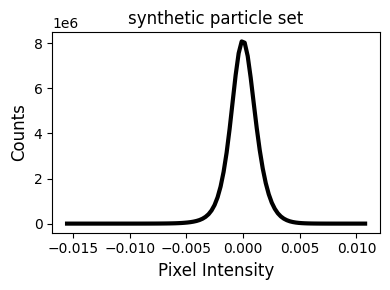

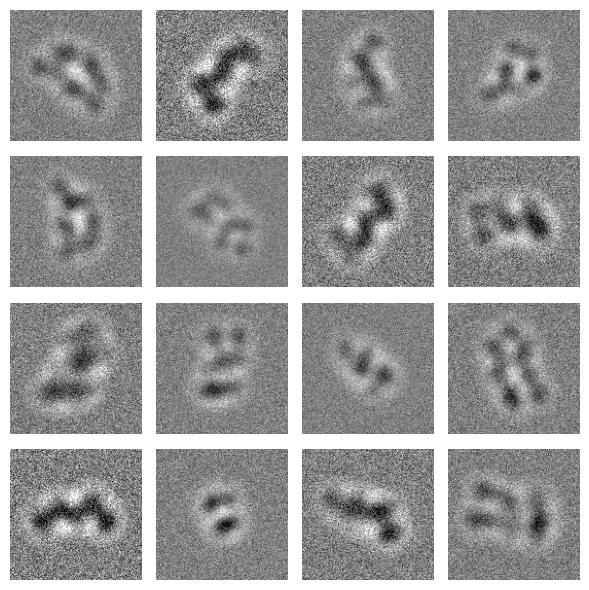

In [3]:
## Load the Synthetic images
images = np.load('%s/images_npix%d_ps%.2f_s%.1f_snr%.1E.npy' % (output_directory, n_pixel, pixel_size, sigma, snr))

## Inspect pixel intensities
fig = plt.figure(figsize=(4, 3), dpi=100)
hist, edges = np.histogram(images.flatten(), bins=100)
ax = fig.add_subplot(111)
ax.plot(edges[:-1], hist, color='k')
ax.set_xlabel('Pixel Intensity')
ax.set_ylabel('Counts')
ax.set_title('synthetic particle set')
plt.tight_layout()

## Visualize the synthetic images
fig = plt.figure(figsize=(6, 6), dpi=100)
for i in range(16):
    ax = fig.add_subplot(4, 4, i+1)
    ax.imshow(images[i], cmap='gray', vmin=-5e-3, vmax=5e-3)
    ax.axis('off')
plt.tight_layout()

**Visualize the MD cluster centers and inspect the cryoEM images**

**Reading the trajectory files for inspection**

In [4]:
# Structure for generating synthetic cryo-EM data ("Ground Truth")
uImage = mda.Universe(data_directory + 'image.pdb', data_directory + 'image.xtc')
# Structure of Initial structural ensemble for reweighting (10 structures chosen by clustering)
uStruc = mda.Universe(data_directory + 'struc.pdb', data_directory + 'struc.xtc')

def mdau_to_pos_arr(u):
    protein_CA = u.select_atoms("protein and name CA")
    pos = torch.zeros((len(u.trajectory), len(protein_CA), 3), dtype=float)
    for i, ts in enumerate(u.trajectory):
        pos[i] = torch.from_numpy(protein_CA.positions)
    pos -= pos.mean(1).unsqueeze(1)
    return pos

posStruc = mdau_to_pos_arr(uStruc)
posImage = mdau_to_pos_arr(uImage)

# check center of mass
assert torch.allclose(posStruc.mean(1), torch.zeros_like(posStruc.mean(1)))
assert torch.allclose(posImage.mean(1), torch.zeros_like(posImage.mean(1)))

nStruc = posStruc.shape[0]
nImage = posImage.shape[0]

print('Number of reference structures: {}'.format(nStruc))
print('Number of images (1 synthetic image per structure): {}'.format(nImage))

Number of reference structures: 10
Number of images (1 synthetic image per structure): 5277


# 1. Inspect landscapes

**Cluster centers and corresponding MD members for each cluster**

/var/folders/_8/h5rr6k3s2995tzxt8b9sqfgh0000gq/T/ipykernel_80884/1782210300.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(posStruc[i, j, 0], posStruc[i, j, 1], posStruc[i, j, 2], s = 10, c = colors[j], marker='o')


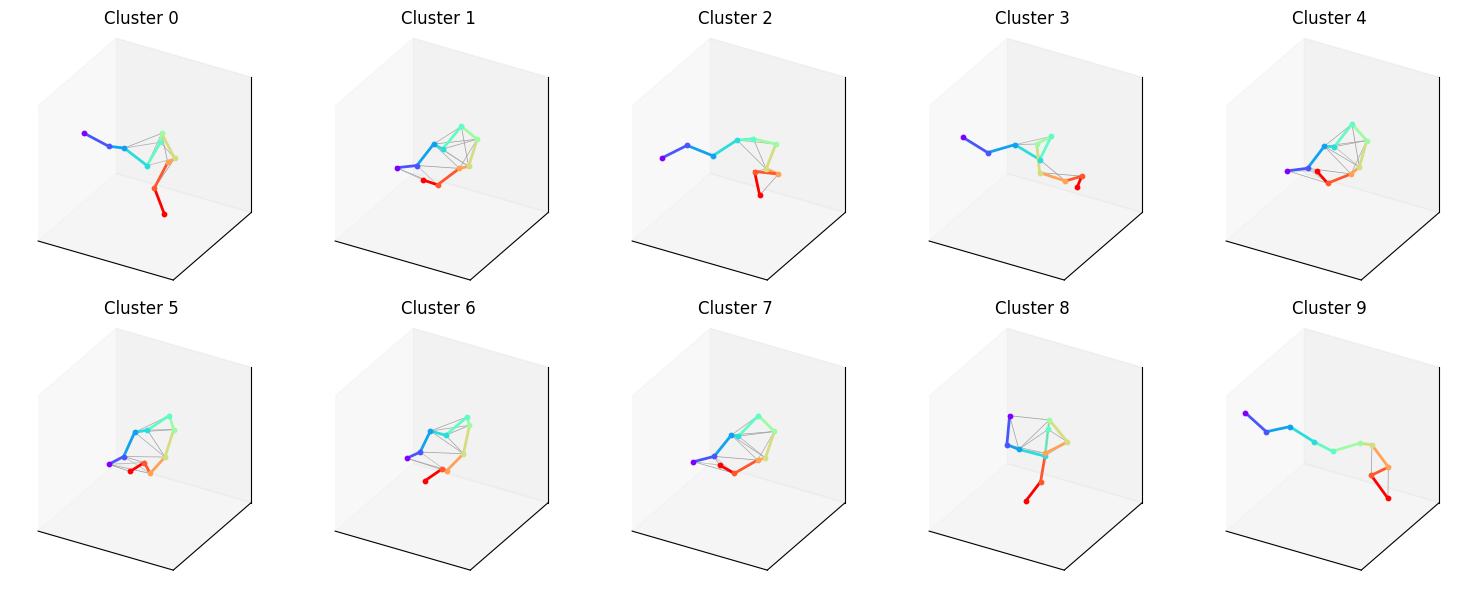

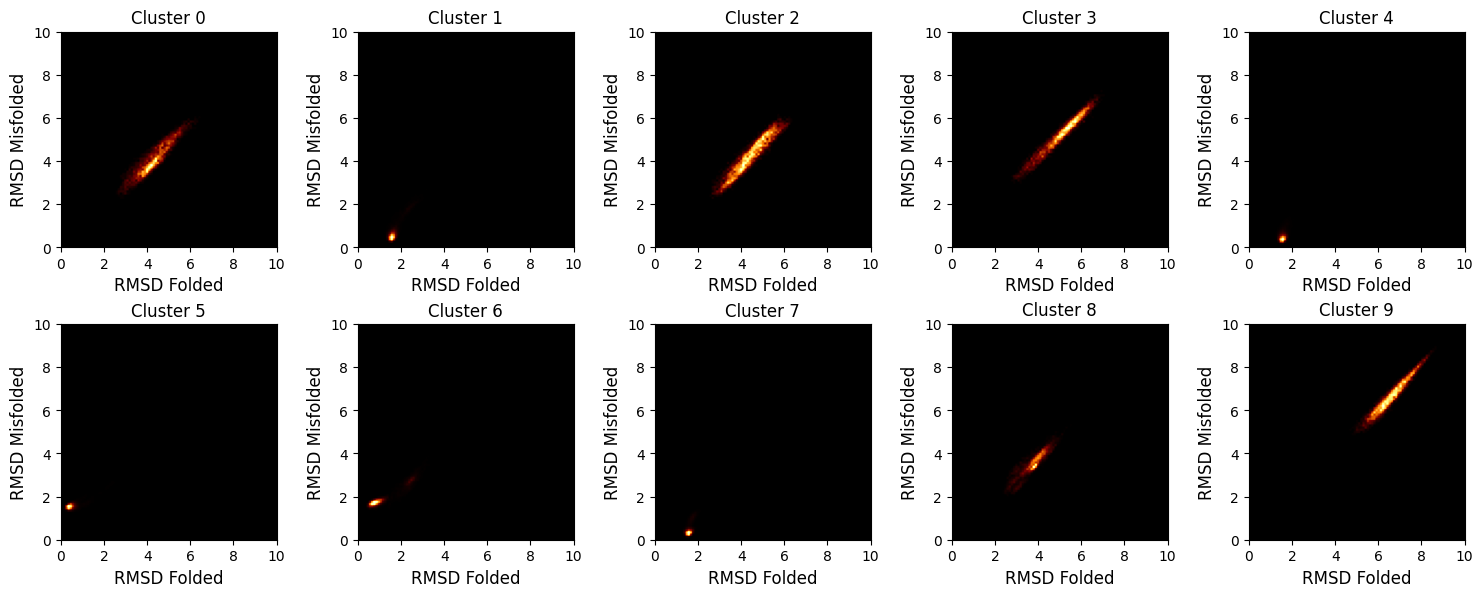

In [5]:
fig = plt.figure(figsize=(15, 6), dpi=100)
for i in range(nCluster):
    ax = fig.add_subplot(2, 5, i+1, aspect='equal', projection='3d', proj_type='ortho')
    nAtom = posStruc[i].shape[0]
    colors = plt.cm.rainbow(np.linspace(0, 1, nAtom))
    for j in range(nAtom):
        ax.scatter(posStruc[i, j, 0], posStruc[i, j, 1], posStruc[i, j, 2], s = 10, c = colors[j], marker='o')
        if j > 0:
            ax.plot([posStruc[i, j-1, 0], posStruc[i, j, 0]], [posStruc[i, j-1, 1], posStruc[i, j, 1]], [posStruc[i, j-1, 2], posStruc[i, j, 2]], color = colors[j], linewidth=2)
        if j < nAtom - 1:
            for k in range(j + 1, nAtom):
                dist = torch.norm(posStruc[i, j] - posStruc[i, k])
                if dist < 6.0:
                    ax.plot([posStruc[i, j, 0], posStruc[i, k, 0]], [posStruc[i, j, 1], posStruc[i, k, 1]], [posStruc[i, j, 2], posStruc[i, k, 2]], color = plt.cm.Greys(dist / 12.0), linewidth=0.5)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    ax.set_zlim(-10, 10)
    ax.set_title('Cluster %d'%i)
plt.tight_layout()
plt.show()

## Initial structural ensemble, the origin trajectory file is not included in the data set
## We only put the CVs of the structural ensemble here for analysis and visualization of the results
## CVs of the structural ensemble where the reference structures are chosen from by clustering
rmsdTrajFolded = np.loadtxt(data_directory + 'rmsdStrucFolded.txt')
rmsdTrajMisfolded = np.loadtxt(data_directory + 'rmsdStrucMisfolded.txt')

## Load the cluster labels and counts
filename_cluster_labels = data_directory + 'cluster_labels.txt'
cluster_labels = np.loadtxt(filename_cluster_labels, dtype=int)
filename_cluster_counts = data_directory + 'cluster_counts.txt'
cluster_counts = np.loadtxt(filename_cluster_counts)
nCluster = len(cluster_counts)

fig = plt.figure(figsize=(15, 6), dpi=100)
xbins = np.linspace(0, 10, 100)
ybins = np.linspace(0, 10, 100)
for i in range(nCluster):
    ax = fig.add_subplot(2, 5, i+1)
    hist, xedges, yedges = np.histogram2d(rmsdTrajFolded[cluster_labels == i], rmsdTrajMisfolded[cluster_labels == i], bins=(xbins,ybins), density=True)
    ax.imshow(hist, cmap='afmhot', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='equal')
    # ax.axis('off')
    ax.set_xlabel('RMSD Folded')
    ax.set_ylabel('RMSD Misfolded')
    ax.set_title('Cluster %d'%i)
plt.tight_layout()
plt.show()

**Plotting script for 2D free energy landscape given two collective variables**

In [6]:
def plot2DFreeEnergy(fig, cv1, cv2, weights = None, 
    nameCV1 = 'CV1', nameCV2 = 'CV2', title = None,
    cv1Min = 0, cv1Max = 10, cv2Min = 0, cv2Max = 10, 
    n_bin = 50, cmap=cmap_fe, vmin=0, vmax=6, alpha=1.0):

    xedges = np.linspace(cv1Min, cv1Max, n_bin)
    yedges = np.linspace(cv2Min, cv2Max, n_bin)
    
    if weights is None:
        H_init, xedges, yedges = np.histogram2d(cv1, cv2, bins=(xedges, yedges), density=True)
    else:
        H_init, xedges, yedges = np.histogram2d(cv1, cv2, bins=(xedges, yedges), density=True, weights=weights)
    
    y_init = -np.log(H_init)
    y_init -= np.amin(y_init)
    y_init[np.isinf(y_init)] = 1e99

    # Plot the RMSD
    xa = .5*(xedges[1:]+xedges[:-1])
    ya = .5*(yedges[1:]+yedges[:-1])

    ax = fig.add_subplot()
    ax.set_position([0.14,0.12,0.85*0.8,0.85])
    ai = ax.imshow(y_init, interpolation='none', origin='lower', cmap=cmap_fe, vmin=vmin, vmax=vmax,
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='equal', alpha=alpha)

    cax = fig.add_subplot()
    cbar = fig.colorbar(ai, cax=cax, ax=ax)
    cax.set_position([0.14+0.85*0.8+0.02,0.12,0.05,0.85])
    cbar.set_label("Free Energy")

    ax.set_xlabel(nameCV2)
    ax.set_ylabel(nameCV1)

    if title is not None:
        ax.set_title(title)

    return ax

**Inspect MD landscape and cluster centers**

/var/folders/_8/h5rr6k3s2995tzxt8b9sqfgh0000gq/T/ipykernel_80884/59564236.py:14: RuntimeWarning: divide by zero encountered in log
  y_init = -np.log(H_init)


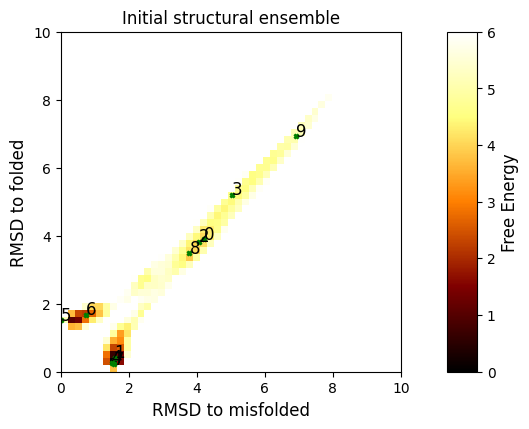

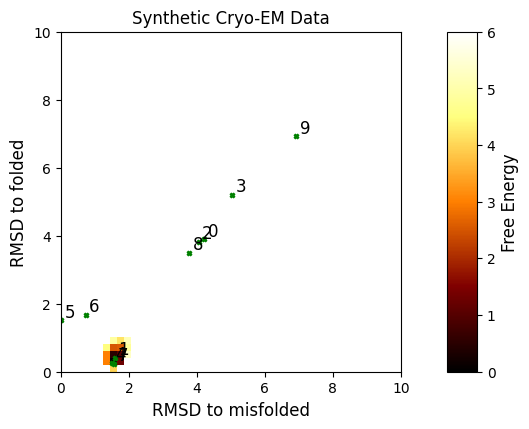

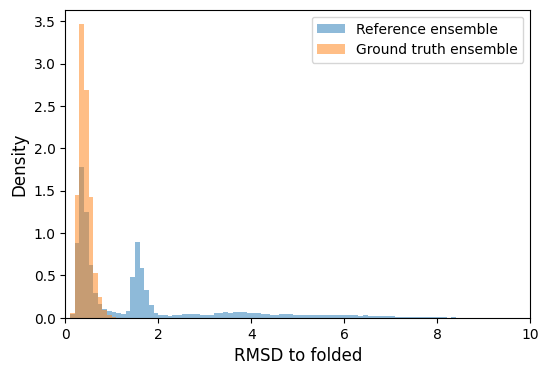

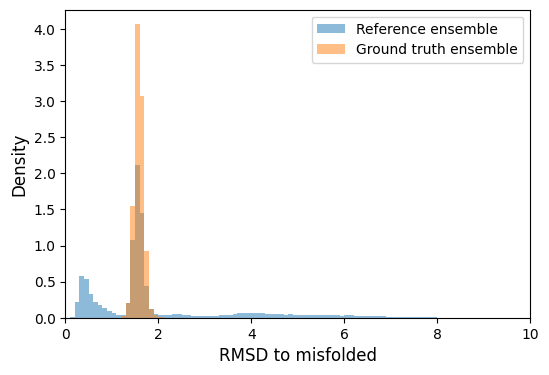

In [21]:
## Reference structures of folded and misfolded states for visualizing 2D Free Energy Landscape
uStrucFolded = mda.Universe(data_directory + 'folded.pdb')
uStrucMisfolded = mda.Universe(data_directory + 'misfolded.pdb')

## Ensure center of mass is at origin
uStrucFolded.atoms.translate(-uStrucFolded.select_atoms('protein and name CA').center_of_mass())
uStrucMisfolded.atoms.translate(-uStrucMisfolded.select_atoms('protein and name CA').center_of_mass())
uImage.atoms.translate(-uImage.select_atoms('protein and name CA').center_of_mass())
uStruc.atoms.translate(-uStruc.select_atoms('protein and name CA').center_of_mass())

## Calculate the RMSD between the first frame of the trajectory and the reference structure
rmsdImageFolded = align.AlignTraj(uImage, uStrucFolded, select='protein and name CA', in_memory=True).run().rmsd
rmsdImageMisfolded = align.AlignTraj(uImage, uStrucMisfolded, select='protein and name CA', in_memory=True).run().rmsd

rmsdStrucFolded = align.AlignTraj(uStruc, uStrucFolded, select='protein and name CA', in_memory=True).run().rmsd
rmsdStrucMisfolded = align.AlignTraj(uStruc, uStrucMisfolded, select='protein and name CA', in_memory=True).run().rmsd

fig = plt.figure(figsize=(6, 4), dpi=100)
ax = plot2DFreeEnergy(fig, rmsdTrajFolded, rmsdTrajMisfolded, nameCV1 = "RMSD to folded", nameCV2 = "RMSD to misfolded", title = "Initial structural ensemble")
ax.scatter(rmsdStrucMisfolded, rmsdStrucFolded, s=10, c='g', marker='X', label='Reference structure')
for i in range(nStruc):
    ax.annotate(i, (rmsdStrucMisfolded[i], rmsdStrucFolded[i]), fontsize=12)
plt.show()

fig = plt.figure(figsize=(6, 4), dpi=100)
ax = plot2DFreeEnergy(fig, rmsdImageFolded, rmsdImageMisfolded, nameCV1 = "RMSD to folded", nameCV2 = "RMSD to misfolded", title = "Synthetic Cryo-EM Data")
ax.scatter(rmsdStrucMisfolded, rmsdStrucFolded, s=10, c='g', marker='X', label='Reference structure')
for i in range(nStruc):
    ax.annotate(i, (rmsdStrucMisfolded[i], rmsdStrucFolded[i]), xytext=(rmsdStrucMisfolded[i]+0.1, rmsdStrucFolded[i]+0.1), fontsize=12)
plt.show()

bins = np.linspace(0,10,101)
fig = plt.figure(figsize=(6, 4), dpi=100)
ax = fig.add_subplot(111)
ax.hist(rmsdTrajFolded, bins=bins, alpha=0.5, label='Reference ensemble', density=True)
ax.hist(rmsdImageFolded, bins=bins, alpha=0.5, label='Ground truth ensemble', density=True)
ax.set_xlabel('RMSD to folded')
ax.set_ylabel('Density')
ax.set_xlim(0,10)
ax.legend()
plt.show()

fig = plt.figure(figsize=(6, 4), dpi=100)
ax = fig.add_subplot(111)
ax.hist(rmsdTrajMisfolded, bins=bins, alpha=0.5, label='Reference ensemble', density=True)
ax.hist(rmsdImageMisfolded, bins=bins, alpha=0.5, label='Ground truth ensemble', density=True)
ax.set_xlabel('RMSD to misfolded')
ax.set_ylabel('Density')
ax.set_xlim(0,10)
ax.legend()
plt.show()

# 2. Likelihood Calculation

In the cryoER posterior $p(\alpha|y)$
$$
    p(\alpha|y)\propto (2 \pi \lambda^2)^{-N_\mathrm{pix}/2} \prod_{i=1}^{N_{\mathrm{image}}} \sum_{m=1}^{N_{\mathrm{struc}}} \exp\left[-\frac{||y_i-F(x_m)||^2}{2\lambda^2}\right] \cdot (\alpha_m N_m),
$$
we evaluate the likelihood $p(y_i|x_m)$ before sampling the posterior for $\alpha_m$ using MCMC. We approximate $\lambda$ for evaluating the likelihood by calculating the noise standard deviation in templates given the SNR level, and calculate image-structure distance $||y_i-F(x_m)||^2$ by calculating the l2-distance between the cryo-EM image and the ``template'' generated from the reference structure along with the forward model and pose parameters.

**Align MD clusters to reference map**

This steps calculate the rotational matrix that aligns the images to the structure, i.e. the reference map that generated the synthetic images, which also means we have knowledge of the pose of the images associated with each reference map. In non-synthetic data, this step would be replaced by pose estimation, i.e., in ab initio reconstruction.

In [8]:
rot_mats_align = align_traj(
    top_image = data_directory + 'image.pdb',
    traj_image = data_directory + 'image.xtc',
    top_struc = data_directory + 'struc.pdb',
    traj_struc = data_directory + 'struc.xtc',
    outdir = output_directory,
    device = device
)
## The command line equivalent of the code:
# os.system("python3 -m cryoER.align_traj \
#     --top_image data_directoryimage.pdb \
#     --traj_image data_directoryimage.xtc \
#     --top_struc data_directorystruc.pdb \
#     --traj_struc data_directorystruc.xtc \
#     --outdir %s \
#     --device %s"%(output_directory, device))

Calculating rotation matrices...


100%|██████████| 1/1 [00:00<00:00, 12.45it/s]

Done!


We approximate $\lambda$ for evaluating the likelihood by calculating the noise standard deviation in templates given the SNR level.

In [9]:
lmbd = approx_lmbd(
    top_struc = data_directory + 'struc.pdb',
    traj_struc = data_directory + 'struc.xtc',
    n_pixel = n_pixel,
    pixel_size = pixel_size,
    sigma = sigma,
    signal_to_noise_ratio = snr,
    add_ctf = True,
    defocus_min = defocus_min,
    defocus_max = defocus_max,
    n_image_per_struc = 100,
    n_batch = 10,
    device = device
)
print("Approximated lambda at SNR %.1e: %.3e" % (snr, lmbd))

## The command line equivalent of the code:
# os.system("python3 -m cryoER.approx_lmbd \
#     --top_struc data_directorystruc.pdb \
#     --traj_struc data_directorystruc.xtc \
#     --n_pixel %d \
#     --pixel_size %.1f \
#     --sigma %.1f \
#     --signal_to_noise_ratio %.1f \
#     --add_ctf \
#     --defocus_min %.3f \
#     --defocus_max %.3f \
#     --n_image_per_struc 100 \
#     --n_batch 1 \
#     --device cuda" % (n_pixel, pixel_size, sigma, snr, defocus_min, defocus_max))

Generating images for batch: 100%|██████████| 100/100 [00:01<00:00, 69.82it/s]

Approximated lambda at SNR 1.0e+00: 1.075e-03


**Calculate image-structure distance matrix**

The image-structure distance $||y_i-F(x_m)||^2$ is calculated using l2-distance between the cryo-EM image and the 'template' generated from the reference structure along with the forward model and pose parameters.

In [10]:
diff_mat = calc_image_struc_distance(
    images = images,
    ctfs = ctfs,
    rot_mats_image = rot_mats_image,
    top_struc = data_directory + 'struc.pdb',
    traj_struc = data_directory + 'struc.xtc',
    rotmat_struc_imgstruc = '%s/rot_mats_struc_image.npy'%output_directory,
    outdir = output_directory,
    n_pixel = n_pixel,
    pixel_size = pixel_size,
    sigma = sigma,
    snr = snr,
    add_ctf = True,
    defocus_min = defocus_min,
    defocus_max = defocus_max,
    batch_size = 32
)
## The command line equivalent of the code:
# image_filename = '%s/images_npix%d_ps%.2f_s%.1f_snr%.1E.npy' % (output_directory, n_pixel, pixel_size, sigma, snr)
# ctfs_filename = '%s/ctfs_npix%d_ps%.2f_s%.1f_snr%.1E.npy' % (output_directory, n_pixel, pixel_size, sigma, snr)
# rot_mats_image_filename = '%s/rot_mats_image_npix%d_ps%.2f_s%.1f_snr%.1E.npy' % (output_directory, n_pixel, pixel_size, sigma, snr)
# os.system("python3 -m cryoER.calc_image_struc_distance \
#   --images %s
#   --ctfs %s
#   --rot_mats_image %s
#   --top_struc data_directorystruc.pdb \
#   --traj_struc data_directorystruc.xtc \
#   --rotmat_struc_imgstruc ./output/rot_mats_struc_image.npy \
#   --outdir ./output/ \
#   --n_pixel %d \
#   --pixel_size %.1f \
#   --sigma %.1f \
#   --signal_to_noise_ratio %.1f \
#   --add_ctf \
#   --defocus_min %.3f \
#   --defocus_max %.3f \
#   --n_batch 1" % (image_filename, ctfs_filename, rot_mats_image_filename, \
#       n_pixel, pixel_size, sigma, snr, defocus_min, defocus_max))

Reading trajectory from ../data/struc.pdb and ../data/struc.xtc...
Reading struc-images alignment matrices from ./output//rot_mats_struc_image.npy...


Computing image-structure distance for structure: 100%|██████████| 10/10 [00:35<00:00,  3.55s/it]

Saving...
Done!


**Inspect the image-structure distance**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


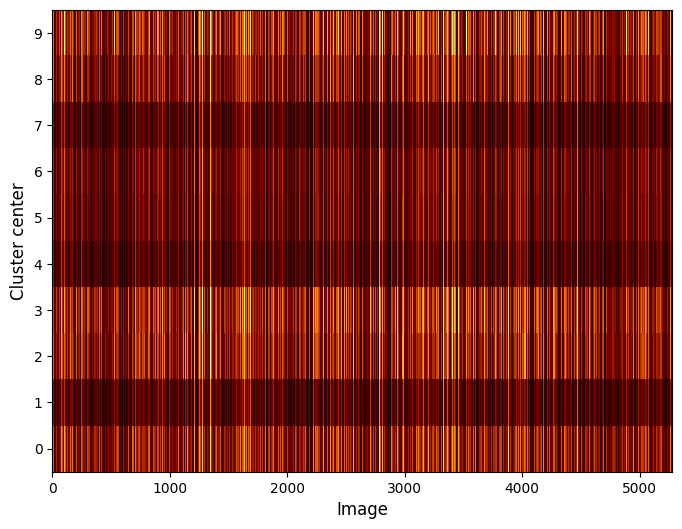

In [11]:
bins = np.linspace(0.0,0.12,101)
diff = np.load(output_directory + "diff_npix%d_ps%.2f_s%.1f_snr%.1E.npy" % (n_pixel, pixel_size, sigma, snr))
fig = plt.figure(figsize=(8, 6), dpi=100)
ax = fig.add_subplot(111)
ax.imshow(diff, cmap='afmhot', origin='lower', aspect='auto', interpolation='none',
    extent=[-0.5, nImage-0.5, -0.5, nCluster-0.5], vmin=0, vmax=0.12)
ax.set_yticks(np.arange(nCluster))
ax.set_xlabel('Image')
ax.set_ylabel('Cluster center')
ax.legend(
    loc='upper right', 
    frameon=False,
)
plt.show()

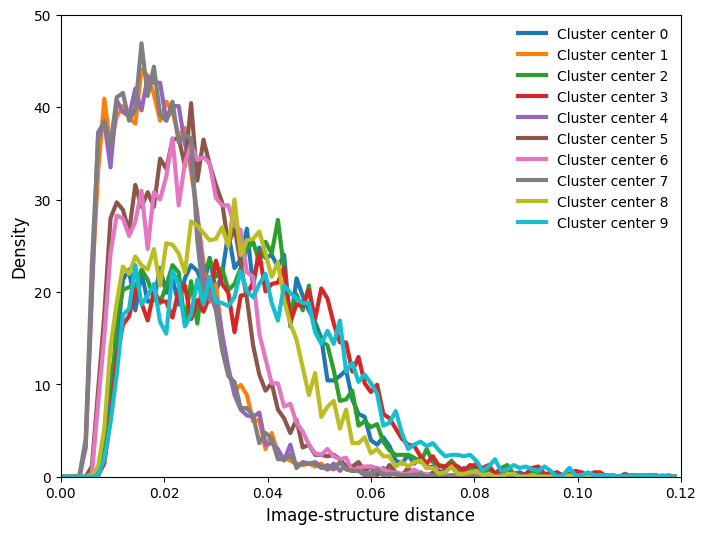

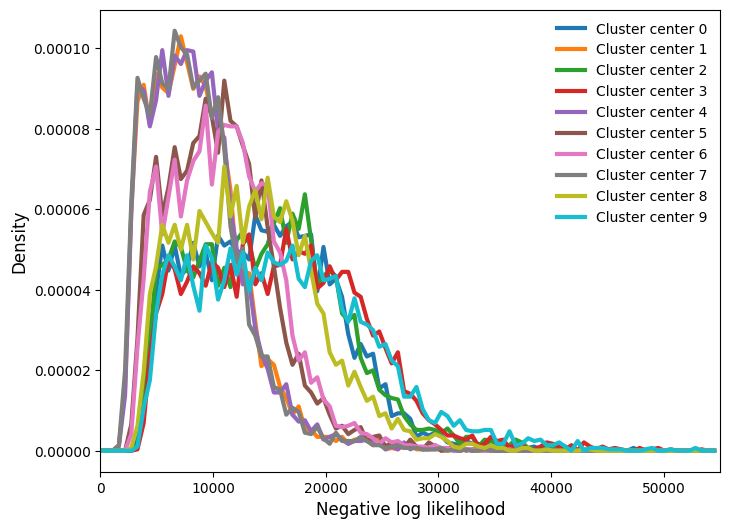

In [12]:
bins = np.linspace(0.0,0.12,101)
diff = np.load(output_directory + "diff_npix%d_ps%.2f_s%.1f_snr%.1E.npy" % (n_pixel, pixel_size, sigma, snr))
fig = plt.figure(figsize=(8, 6), dpi=100)
ax = fig.add_subplot(111)
for i in range(nCluster):
    hist, edges = np.histogram(diff[i], bins=bins, density=True)
    ax.plot(edges[:-1], hist, label='Cluster center %d'%i)
ax.set_xlim(edges[0], edges[-1])
ax.set_ylim(0, 50)
ax.set_xlabel('Image-structure distance')
ax.set_ylabel('Density')
ax.legend(
    loc='upper right', 
    frameon=False,
)
plt.show()

bins = np.linspace(0,55000,101)
nll = diff / (2 * lmbd**2)
fig = plt.figure(figsize=(8, 6), dpi=100)
ax = fig.add_subplot(111)
for i in range(nCluster):
    hist, edges = np.histogram(nll[i], bins=bins, density=True)
    ax.plot(edges[:-1], hist, label='Cluster center %d'%i)
ax.set_xlim(bins[0], bins[-1])
# ax.set_ylim(0, 0.00012)
ax.set_xlabel('Negative log likelihood')
ax.set_ylabel('Density')
ax.legend(
    loc='upper right', 
    frameon=False,
)

# 3. Plug everything into the posterior and run MCMC

We have gathered all the ingredients we need to put together the cryoER posterior 
$$
    p(\alpha|y)\propto (2 \pi \lambda^2)^{-N_\mathrm{pix}/2} \prod_{i=1}^{N_{\mathrm{image}}} \sum_{m=1}^{N_{\mathrm{struc}}} \exp\left[-\frac{||y_i-F(x_m)||^2}{2\lambda^2}\right] \cdot (\alpha_m N_m),
$$
Let's start cooking by putting the image-structure distance matrix, the estimated image pixel standard deviation $\lambda$, and the cluster counts $N_m$ into the MCMC function and sampling the posterior with Stan (the MCMC software).

In [13]:
os.system("rm -rf %s/Stan_output/*"%output_directory) ## remove the stan output from previous runs

n_MCMC_chains = 4
n_MCMC_warmup = 100
n_MCMC_iter = 1000

run_cryoER_mcmc(
    infileclustersize = filename_cluster_counts,
    infileimagedistance = ['%s/diff_npix%d_ps%.2f_s%.1f_snr%.1E.npy' % (output_directory, n_pixel, pixel_size, sigma, snr)],
    outdir = output_directory,
    lmbd = lmbd,
    chains = n_MCMC_chains,
    iter_warmup = n_MCMC_warmup,
    iter_sampling = n_MCMC_iter,
    parallel_chains = 4,
    threads_per_chain = 8
)
## The command line equivalent of the code:
# os.system(" python3 -m cryoER.run_cryoER_mcmc \
#   --infileclustersize %s \
#   --infileimagedistance %s/diff_npix%d_ps%.2f_s%.1f_snr%.1E.npy \
#   --outdir output/ \
#   --lmbd %.1e \
#   --chains 4 \
#   --iterwarmup 10 \
#   --itersample 100 \
#   --parallelchain 4 \
#   --threadsperchain 8"  % (filename_cluster_counts, output_directory, n_pixel, pixel_size, sigma, snr, lmbd))

Number of structures = 10, Number of images = 5277.


17:23:42 - cmdstanpy - INFO - CmdStan start processing


{'stan_version_major': '2', 'stan_version_minor': '33', 'stan_version_patch': '0', 'STAN_THREADS': 'true', 'STAN_MPI': 'false', 'STAN_OPENCL': 'false', 'STAN_NO_RANGE_CHECKS': 'false', 'STAN_CPP_OPTIMS': 'false'}
method = sample (Default)
sample
num_samples = 1000 (Default)
num_warmup = 100
save_warmup = 0 (Default)
thin = 1 (Default)
adapt
engaged = 1 (Default)
gamma = 0.050000000000000003 (Default)
delta = 0.80000000000000004 (Default)
kappa = 0.75 (Default)
t0 = 10 (Default)
init_buffer = 75 (Default)
term_buffer = 50 (Default)
window = 25 (Default)
algorithm = hmc (Default)
hmc
engine = nuts (Default)
nuts
max_depth = 10 (Default)
metric = diag_e (Default)
metric_file =  (Default)
stepsize = 1 (Default)
stepsize_jitter = 0 (Default)
num_chains = 4
id = 1 (Default)
data
file = ././output//Dmat.json
init = 2 (Default)
random
seed = 81899
output
file = /var/folders/_8/h5rr6k3s2995tzxt8b9sqfgh0000gq/T/tmpw_aw105a/cryo-eruiiyhu8e/cryo-er-20231116172342.csv
diagnostic_file =  (Default)
r

17:25:38 - cmdstanpy - INFO - CmdStan done processing


Chain [4] Iteration: 1100 / 1100 [100%]  (Sampling)

Elapsed Time: 12.474 seconds (Warm-up)
103.75 seconds (Sampling)
116.224 seconds (Total)




Done!


# 4. Analyze MCMC output

The analyze_mcmc function takes the output from the MCMC sampling and calculates the average and standard deviation for the reweighting factors $\{\alpha_m\}$. 

['cryo-er-20231116172342_1.csv', 'cryo-er-20231116172342_2.csv', 'cryo-er-20231116172342_3.csv', 'cryo-er-20231116172342_4.csv']


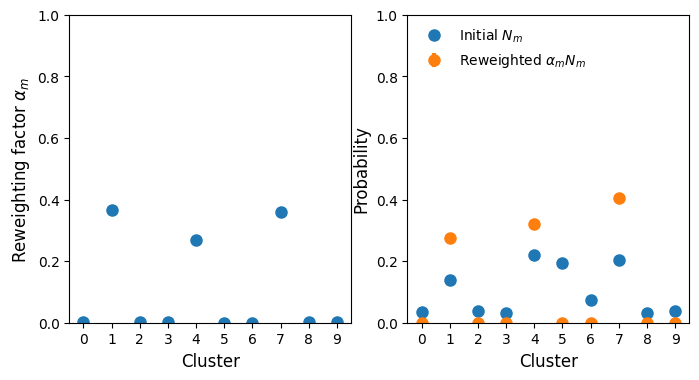

In [14]:
# This function takes the Stan MCMC output and convert to average weights with standard deviation
factor_mean_std, rewtprob_mean_std, lp, log_weights_mc_chains = analyze_mcmc(
    output_directory = output_directory,
    filename_cluster_counts = filename_cluster_counts,
)
Nm = cluster_counts.astype(float)
Nm /= np.sum(Nm)

# factor_mean, factor_std = np.loadtxt(output_directory+"reweighting_factor.txt", unpack=True)
factor_mean = factor_mean_std[:,0]
factor_std = factor_mean_std[:,1]
M = len(factor_mean)

fig = plt.figure(figsize=(8, 4), dpi=100)
ax1 = fig.add_subplot(121)
ax1.errorbar(np.arange(M), factor_mean, yerr=factor_std, fmt='o')
ax1.set_xlabel("Cluster")
ax1.set_ylabel(r"Reweighting factor $\alpha_m$")

ax1.set_xticks(np.arange(0, M, 1))
ax1.set_yticks(np.arange(0,1.01,0.2))
ax1.set_xlim(-0.5, M-0.5)
ax1.set_ylim(0, 1.0)

# rewtprob_mean, rewtprob_std = np.loadtxt(output_directory+"reweighted_prob.txt", unpack=True)
rewtprob_mean = rewtprob_mean_std[:,0]
rewtprob_std = rewtprob_mean_std[:,1]
ax2 = fig.add_subplot(122)
ax2.plot(np.arange(M), Nm, 'o', label=r"Initial $N_m$")
ax2.errorbar(np.arange(M), rewtprob_mean, yerr=rewtprob_std, fmt='o', label=r"Reweighted $\alpha_m N_m$")
ax2.set_xlabel("Cluster")
ax2.set_ylabel("Probability")
ax2.legend(
    loc='upper left',
    frameon=False,
)
ax2.set_xticks(np.arange(0, M, 1))
ax2.set_yticks(np.arange(0,1.01,0.2))
ax2.set_xlim(-0.5, M-0.5)
ax2.set_ylim(0, 1.0)

plt.show()

**Inspect the MCMC chain samples**

This shows the sampled weights for each cluster center of each iteration in the MCMC chain.

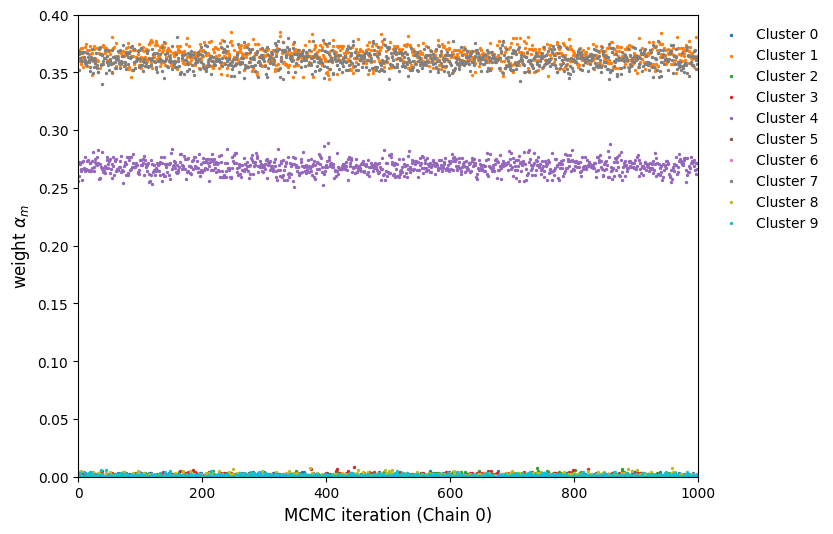

In [15]:
fig = plt.figure(figsize=(8, 6), dpi=100)
ax1 = fig.add_subplot(111)
for i in range(nCluster):
    ax1.scatter(range(n_MCMC_iter), np.exp(log_weights_mc_chains[0,:,i]), s = 2, label='Cluster %d'%i)
ax1.set_xlim(0, n_MCMC_iter)
ax1.set_ylim(0, 0.40)
ax1.set_xlabel("MCMC iteration (Chain 0)")
ax1.set_ylabel(r"weight $\alpha_m$")
ax1.legend(
    bbox_to_anchor=(1.01, 1),
    frameon=False,
)
plt.show()

**Inspect the log posterior of each MCMC chain**

There is nothing interesting for this example, it should be a straight line because the MCMC chains already converged by the end of the warmup phase

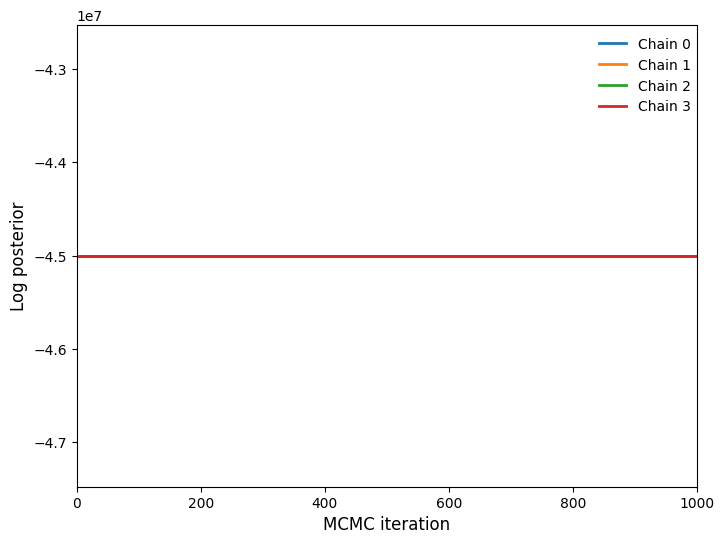

In [16]:
fig = plt.figure(figsize=(8, 6), dpi=100)
ax1 = fig.add_subplot(111)
lp_norm = lp - (n_pixel ** 2 / 2 * np.log(2 * np.pi * lmbd ** 2))  # properly normalized log posterior
for i in range(n_MCMC_chains):
    ax1.plot(range(n_MCMC_iter), lp_norm[i,:], lw = 2, label='Chain %d'%i)
# ax1.set_ylim(np.amin(lp_norm), np.amax(lp_norm))
ax1.set_xlim(0, n_MCMC_iter)
ax1.set_xlabel("MCMC iteration")
ax1.set_ylabel("Log posterior")
ax1.legend(
    bbox_to_anchor=(1.01, 1),
    frameon=False,
)
plt.show()

**Inspect Posterior distribution of log weights sampled by MCMC**

We should expect a converged set of weights would have a monomodal distribution of posterior samples. Otherwise, we should either increase the MCMC samples (continue doing the sampling), or investigate if there is something wrong with the dataset (is it too noisy?), the structures (indistinguishable from each other?), or the forward model (is the pose / CTF estimation too inaccurate?).

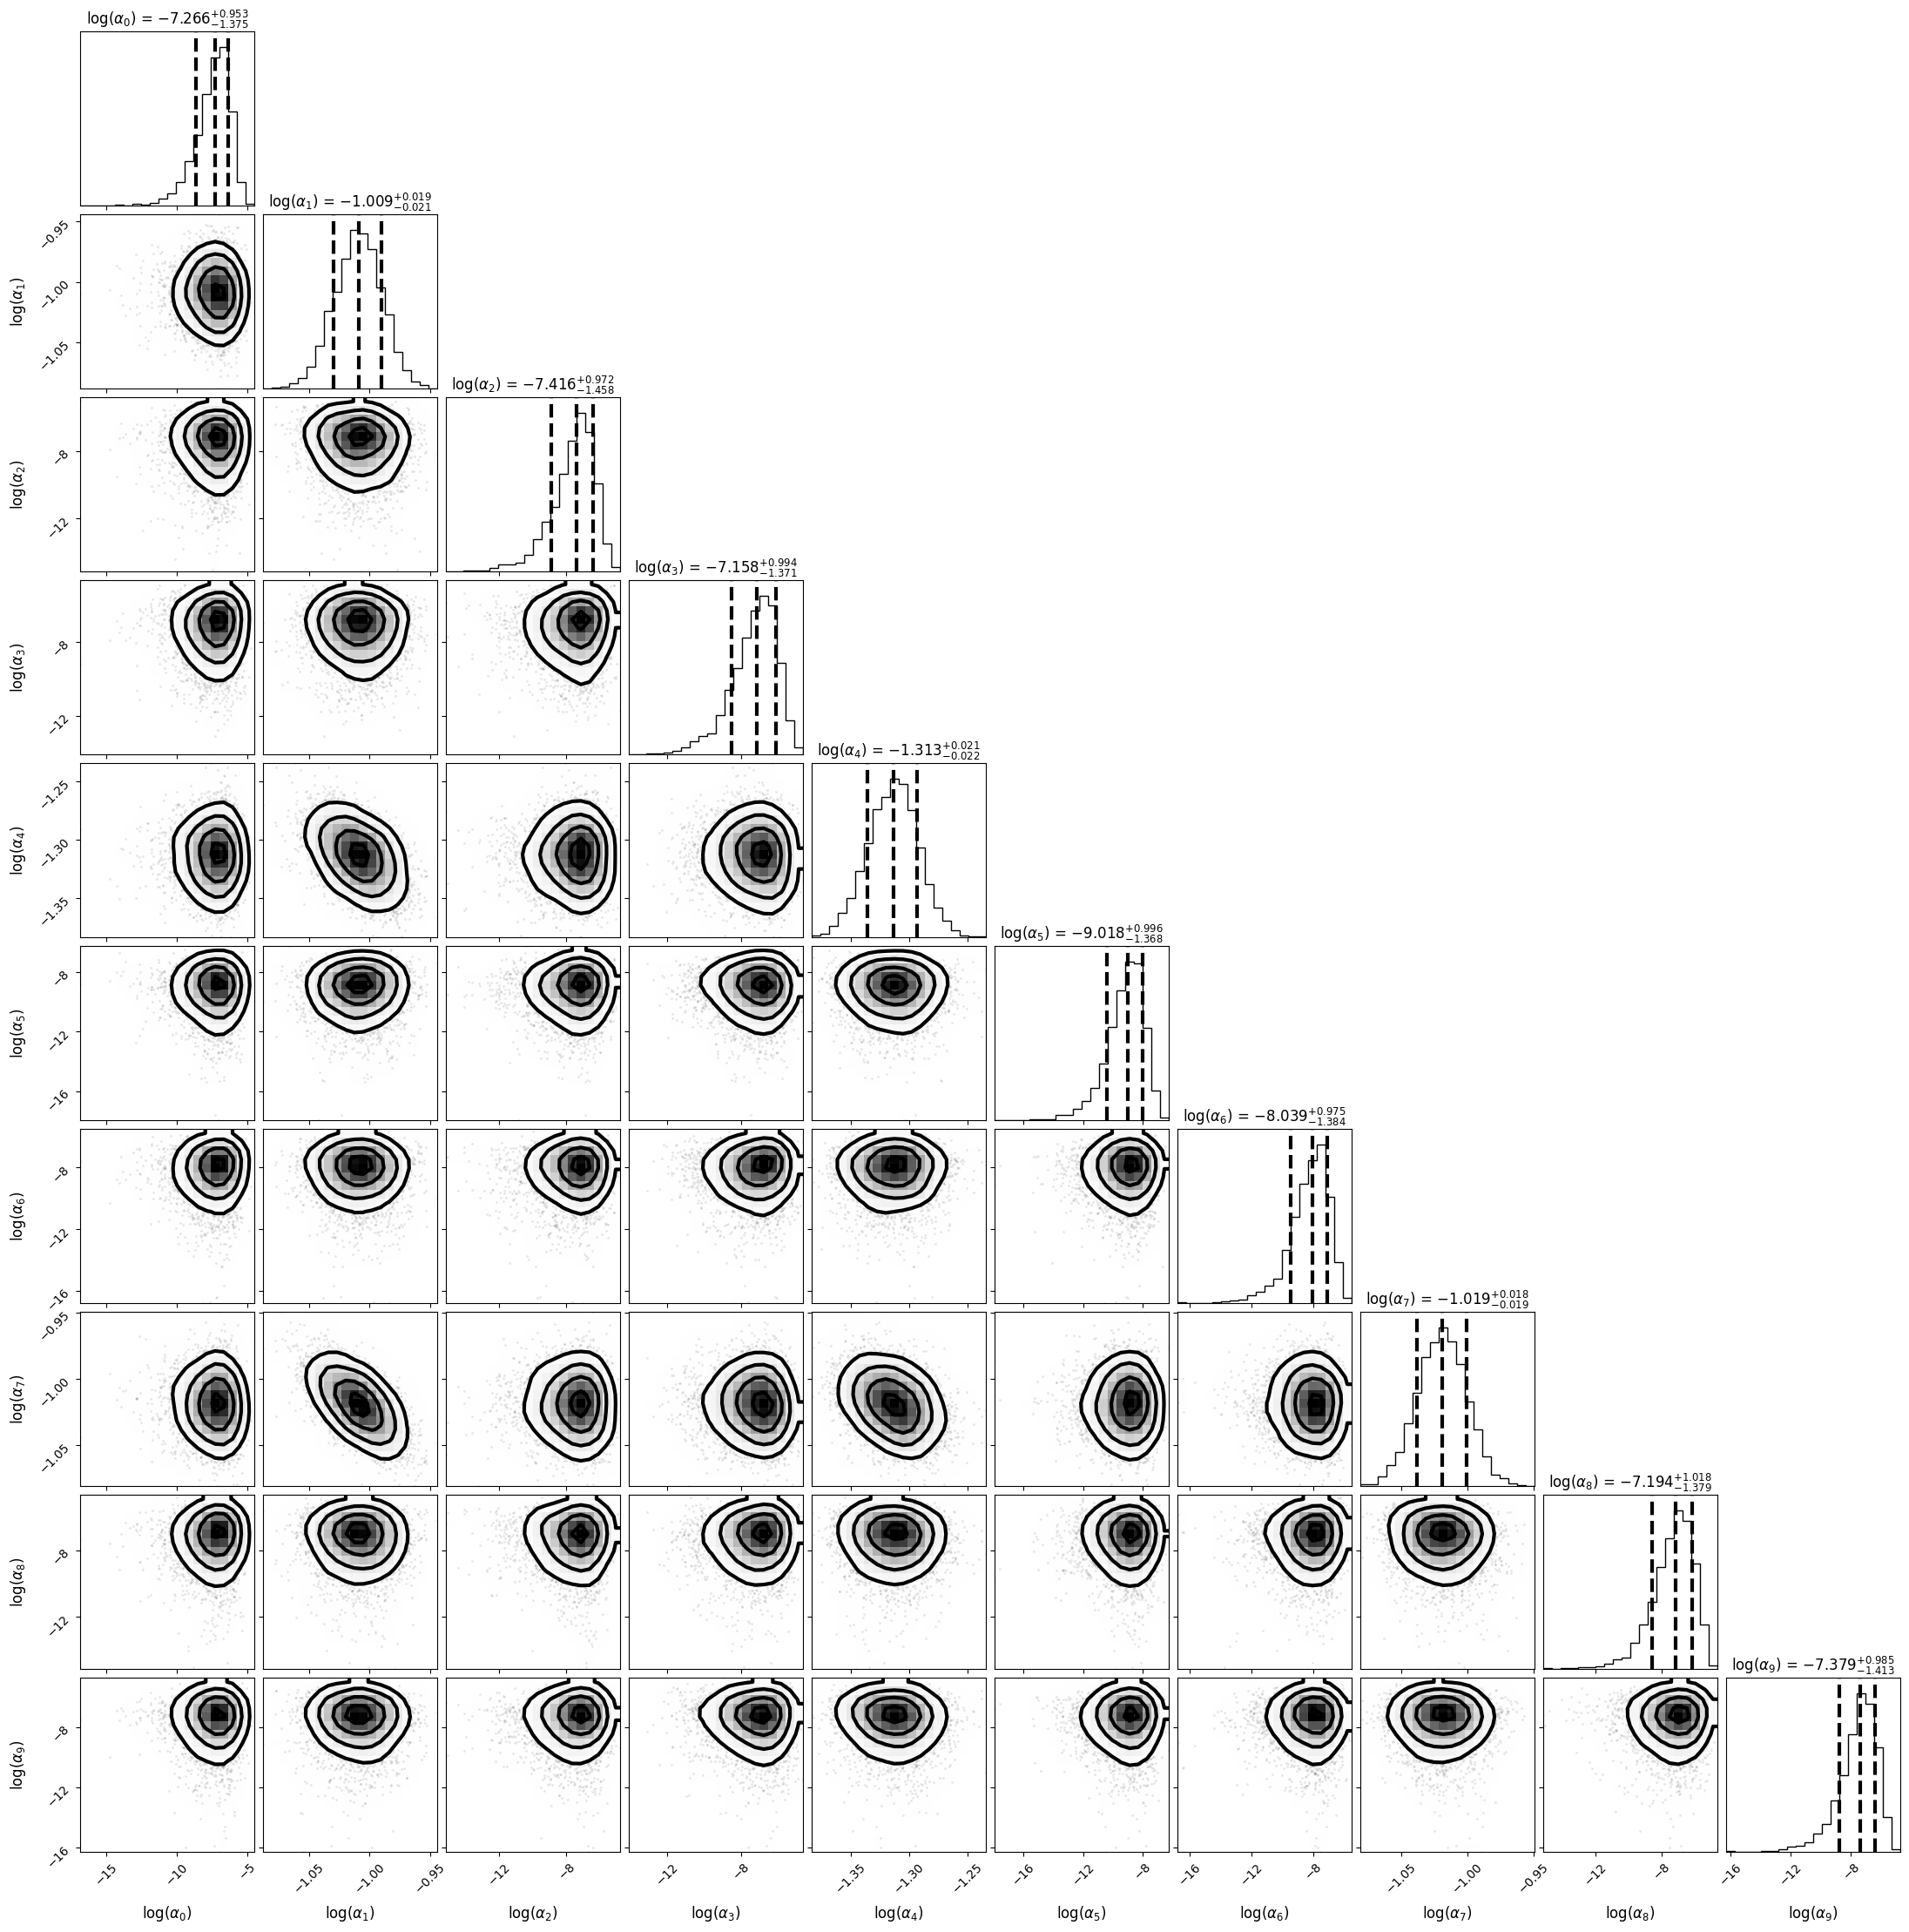

In [17]:
import corner   # pip install corner
figure = corner.corner(
    log_weights_mc_chains.reshape((-1, nCluster)),
    labels=[r"log($\alpha_{%d}$)"%i for i in range(nCluster)],
    quantiles=[0.16, 0.5, 0.84],    # 1-sigma contours
    show_titles=True,
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 12},
    title_fmt='.3f',
    truth_color='r',
    hist_kwargs={"density": True},
    max_n_ticks=3,
    smooth=1.0
)

# 5. Visualize the reweighted FE

Now we can use this to reweight the landscape. Recall the posterior with respect to the reweighting factors $\{\alpha_m\}$ is
$$
    p(\mathbf{A}|\mathbf{Y}, \mathbf{X}) = \prod_{i=1}^{N_{\mathrm{image}}} \sum_{m=1}^{N_{\mathrm{struc}}} p(y_i|x_m) \cdot p(x_m | \alpha_m)
$$
where $p(x_m | \alpha_m) = \alpha_m N_m$, the probability of structure $x_m$ given the reweighting factor $\alpha_m$. To reweight the landscape from the original MD landscape, we are calculating the probability of each structure $x_t$ in the MD, where we have put an assumption that every MD structure in the same cluster shares the same probability, i.e. $p(x_t | \{\alpha_m\}) = p(x_m | \alpha_m) / N_m = \alpha_m$ for $x_t$ in cluster $m$. Therefore, it is as simple as multiplying the reweighting factor $\alpha_m$ to the ensemble probability of each structure $x_t$ in the MD landscape (which is assumed to be uniform), therefore, $\alpha_t = \alpha_m$ for $x_t$ in cluster $m$.

/var/folders/_8/h5rr6k3s2995tzxt8b9sqfgh0000gq/T/ipykernel_80884/59564236.py:14: RuntimeWarning: divide by zero encountered in log
  y_init = -np.log(H_init)


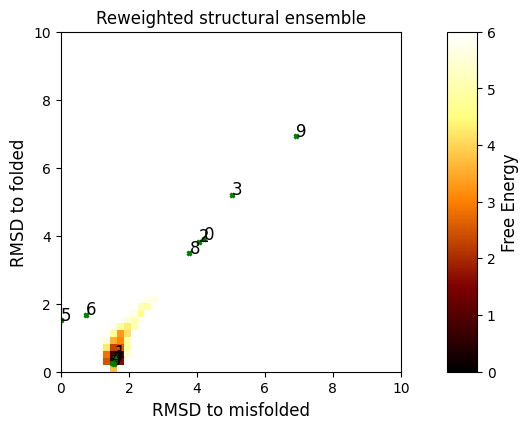

In [18]:
# Reweighted structural ensemble
cluster_labels = np.loadtxt(filename_cluster_labels, dtype=int) # m of each structure x_t
weights = np.array(factor_mean)[cluster_labels] # weight \alpha_t = \alpha_m
fig = plt.figure()
ax = plot2DFreeEnergy(fig, rmsdTrajFolded, rmsdTrajMisfolded, weights = weights, nameCV1 = "RMSD to folded", nameCV2 = "RMSD to misfolded", title = "Reweighted structural ensemble")
ax.scatter(rmsdStrucMisfolded, rmsdStrucFolded, s=10, c='g', marker='X', label='Reference structure')
for i in range(nStruc):
    ax.annotate(i, (rmsdStrucMisfolded[i], rmsdStrucFolded[i]), fontsize=12)
plt.show()

**Example script for perform K-Medoids clustering on trajectory**

In [19]:
### EXAMPLE ONLY, NOT RUNNABLE HERE, REQUIRES THE LONG TRAJECTORY FILE ###

import numpy as np
from tqdm import tqdm
import numpy as np
import time, os
import sys

### extra modules needed for this part
import mdtraj as md
import kmedoids
###

# load the trajectory

gro_file = "struc.gro"
xtc_file = "struc_whole_traj.xtc"
t = md.load(xtc_file, top=top_file)
atom_indices = [a.index for a in t.topology.atoms if a.name == 'CA']

# calculate pairwise RMSD
distances = np.empty((t.n_frames, t.n_frames), dtype=np.float32)
for i in tqdm(range(t.n_frames)):       # this is a long calculation!!
    distances[i,:] = md.rmsd(t, t, i, atom_indices=atom_indices, parallel=True)
print('Max pairwise rmsd: %f nm' % np.max(distances))
np.save("distances_self_pairwise.npy", distances)

# perform k-medoids clustering
nCluster = 10
c = kmedoids.fasterpam(distances, nCluster)
labels = c.labels
medoids = c.medoids
unique, counts = np.unique(labels, return_counts=True)

np.savetxt("cluster_labels.txt", labels, fmt="%d")      # save the cluster labels for each frame in the trajectory
np.savetxt("cluster_medoids.txt", medoids, fmt="%d")    # save the medoids as frame numbers in the trajectory
np.savetxt("cluster_counts.txt", counts, fmt="%d")      # save the number of members in each cluster

ModuleNotFoundError: No module named 'mdtraj'